In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dropout, BatchNormalization, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import joblib
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

pd.pandas.set_option('display.max_columns',None)

In [2]:
accidents = pd.read_csv("Accident_Information.csv", encoding='latin1')
vehicles = pd.read_csv("Vehicle_Information.csv", encoding='latin1')

/var/folders/gn/clhq9k9140jfd9jjcjjjpqvh0000gn/T/ipykernel_34706/4028209302.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("Accident_Information.csv", encoding='latin1')


Data Cleaning for the Accidents Dataframe

In [3]:
accidents.head(10)

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,NaN,2005-01-04,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.489096,Daylight,Kensington and Chelsea,Kensington and Chelsea,525680.0,178240.0,-0.191170,E01002849,1,1,0.0,1.0,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,17:42,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,NaN,2005-01-05,Wednesday,1.0,Auto traffic signal,Crossroads,51.520075,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524170.0,181650.0,-0.211708,E01002909,1,1,0.0,5.0,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,17:36,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,NaN,2005-01-06,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.525301,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524520.0,182240.0,-0.206458,E01002857,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,00:15,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,NaN,2005-01-07,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.482442,Daylight,Kensington and Chelsea,Kensington and Chelsea,526900.0,177530.0,-0.173862,E01002840,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,10:35,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,NaN,2005-01-10,Monday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.495752,Darkness - lighting unknown,Kensington and Chelsea,Kensington and Chelsea,528060.0,179040.0,-0.156618,E01002863,1,1,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,21:13,Urban,Fine no high winds,2005,No
5,200501BS00006,Unclassified,0.0,NaN,0.0,Slight,NaN,2005-01-11,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.515540,Daylight,Kensington and Chelsea,Kensington and Chelsea,524770.0,181160.0,-0.203238,E01002832,1,2,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,Oil or diesel,30.0,12:40,Urban,Raining no high winds,2005,No
6,200501BS00007,C,0.0,Unclassified,0.0,Slight,NaN,2005-01-13,Thursday,1.0,Give way or uncontrolled,T or staggered junction,51.512695,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524220.0,180830.0,-0.211277,E01002875,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,20:40,Urban,Fine no high winds,2005,No
7,200501BS00009,A,315.0,NaN,0.0,Slight,NaN,2005-01-14,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.502260,Daylight,Kensington and Chelsea,Kensington and Chelsea,525890.0,179710.0,-0.187623,E01002889,2,1,0.0,0.0,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,17:35,Urban,Fine no high winds,2005,No
8,200501BS00010,A,3212.0,B,304.0,Slight,NaN,2005-01-15,Saturday,1.0,Auto traffic signal,Crossroads,51.483420,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,527350.0,177650.0,-0.167342,E01002900,2,2,0.0,5.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,22:43,Urban,Fine no high winds,2005,No
9,200501BS00011,B,450.0,C,0.0,Slight,NaN,2005-01-15,Saturday,1.0,Give way or uncontrolled,T or staggered junction,51.512443,Daylight,Kensington and Chelsea,Kensington and Chelsea,524550.0,180810.0,-0.206531,E01002875,5,2,0.0,8.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,16:00,

In [4]:
accidents.shape

(2047256, 34)

In [5]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 34 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   Accident_Index                               object 
 1   1st_Road_Class                               object 
 2   1st_Road_Number                              float64
 3   2nd_Road_Class                               object 
 4   2nd_Road_Number                              float64
 5   Accident_Severity                            object 
 6   Carriageway_Hazards                          object 
 7   Date                                         object 
 8   Day_of_Week                                  object 
 9   Did_Police_Officer_Attend_Scene_of_Accident  float64
 10  Junction_Control                             object 
 11  Junction_Detail                              object 
 12  Latitude                                     float64
 13  Light_Condit

In [6]:
accidents.isnull().sum()

Accident_Index                                       0
1st_Road_Class                                       0
1st_Road_Number                                      2
2nd_Road_Class                                  844272
2nd_Road_Number                                  17593
Accident_Severity                                    0
Carriageway_Hazards                            2007807
Date                                                 0
Day_of_Week                                          0
Did_Police_Officer_Attend_Scene_of_Accident        278
Junction_Control                                     0
Junction_Detail                                      0
Latitude                                           174
Light_Conditions                                     0
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
Location_Easting_OSGR                              164
Location_Northing_OSGR                             164
Longitude 

In [7]:
#Handle missing values for datetime variables

#Convert to datetime
accidents['Time'] = pd.to_datetime(accidents['Time'], format='%H:%M', errors='coerce')

#Impute the null values of the datetime column
# Step 2: Find the most frequent time
most_frequent_time = accidents['Time'].mode()[0]

# Step 3: Fill null values with the most frequent time
accidents['Time'].fillna(most_frequent_time, inplace=True)

In [8]:
#Replace null vlaues
#Fill the number columns
number_columns_to_fill = [
    '2nd_Road_Number',
    'Pedestrian_Crossing-Physical_Facilities',
    'Pedestrian_Crossing-Human_Control',
    '1st_Road_Number',
    'Speed_limit'
]

for column in number_columns_to_fill:
    accidents[column].fillna(accidents[column].mean(), inplace=True)
 
#Fill the categorical columns    
object_columns_to_fill = [
    'LSOA_of_Accident_Location',
    'Did_Police_Officer_Attend_Scene_of_Accident',
    'InScotland'
]

for column in object_columns_to_fill:
    accidents[column].fillna(accidents[column].mode()[0], inplace= True)


In [9]:
#Imputing columns with geographical data
# Initialize KNN imputer
imputer = KNNImputer(n_neighbors = 6)

# List of columns to impute
columns_to_impute = ['Latitude',
                     'Longitude',
                     'Location_Easting_OSGR',
                    'Location_Northing_OSGR'
]

# Fit and transform the data
accidents[columns_to_impute] = pd.DataFrame(imputer.fit_transform(accidents[columns_to_impute]), columns=columns_to_impute)
accidents.head(10)



,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,NaN,2005-01-04,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.489096,Daylight,Kensington and Chelsea,Kensington and Chelsea,525680.0,178240.0,-0.191170,E01002849,1,1,0.0,1.0,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,1900-01-01 17:42:00,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,NaN,2005-01-05,Wednesday,1.0,Auto traffic signal,Crossroads,51.520075,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524170.0,181650.0,-0.211708,E01002909,1,1,0.0,5.0,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,1900-01-01 17:36:00,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,NaN,2005-01-06,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.525301,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524520.0,182240.0,-0.206458,E01002857,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,1900-01-01 00:15:00,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,NaN,2005-01-07,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.482442,Daylight,Kensington and Chelsea,Kensington and Chelsea,526900.0,177530.0,-0.173862,E01002840,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,1900-01-01 10:35:00,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,NaN,2005-01-10,Monday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.495752,Darkness - lighting unknown,Kensington and Chelsea,Kensington and Chelsea,528060.0,179040.0,-0.156618,E01002863,1,1,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,1900-01-01 21:13:00,Urban,Fine no high winds,2005,No
5,200501BS00006,Unclassified,0.0,NaN,0.0,Slight,NaN,2005-01-11,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.515540,Daylight,Kensington and Chelsea,Kensington and Chelsea,524770.0,181160.0,-0.203238,E01002832,1,2,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,Oil or diesel,30.0,1900-01-01 12:40:00,Urban,Raining no high winds,2005,No
6,200501BS00007,C,0.0,Unclassified,0.0,Slight,NaN,2005-01-13,Thursday,1.0,Give way or uncontrolled,T or staggered junction,51.512695,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524220.0,180830.0,-0.211277,E01002875,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,1900-01-01 20:40:00,Urban,Fine no high winds,2005,No
7,200501BS00009,A,315.0,NaN,0.0,Slight,NaN,2005-01-14,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.502260,Daylight,Kensington and Chelsea,Kensington and Chelsea,525890.0,179710.0,-0.187623,E01002889,2,1,0.0,0.0,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,1900-01-01 17:35:00,Urban,Fine no high winds,2005,No
8,200501BS00010,A,3212.0,B,304.0,Slight,NaN,2005-01-15,Saturday,1.0,Auto traffic signal,Crossroads,51.483420,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,527350.0,177650.0,-0.167342,E01002900,2,2,0.0,5.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,1900-01-01 22:43:00,Urban,Fine no high winds,2005,No
9,200501BS00011,B,450.0,C,0.0,Slight,NaN,2005-01-15,Saturday,1.0,Give way or uncontrolled,T or staggered junction,51.512443,Daylight,Kensington and Chelsea,Kensi

In [10]:
accidents.isnull().sum()

Accident_Index                                       0
1st_Road_Class                                       0
1st_Road_Number                                      0
2nd_Road_Class                                  844272
2nd_Road_Number                                      0
Accident_Severity                                    0
Carriageway_Hazards                            2007807
Date                                                 0
Day_of_Week                                          0
Did_Police_Officer_Attend_Scene_of_Accident          0
Junction_Control                                     0
Junction_Detail                                      0
Latitude                                             0
Light_Conditions                                     0
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
Location_Easting_OSGR                                0
Location_Northing_OSGR                               0
Longitude 

In [11]:
accidents.drop( columns = ['Carriageway_Hazards'], inplace= True)
accidents.head(10)

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,2005-01-04,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.489096,Daylight,Kensington and Chelsea,Kensington and Chelsea,525680.0,178240.0,-0.191170,E01002849,1,1,0.0,1.0,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,1900-01-01 17:42:00,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,2005-01-05,Wednesday,1.0,Auto traffic signal,Crossroads,51.520075,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524170.0,181650.0,-0.211708,E01002909,1,1,0.0,5.0,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,1900-01-01 17:36:00,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,2005-01-06,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.525301,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524520.0,182240.0,-0.206458,E01002857,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,1900-01-01 00:15:00,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,2005-01-07,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.482442,Daylight,Kensington and Chelsea,Kensington and Chelsea,526900.0,177530.0,-0.173862,E01002840,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,1900-01-01 10:35:00,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,2005-01-10,Monday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.495752,Darkness - lighting unknown,Kensington and Chelsea,Kensington and Chelsea,528060.0,179040.0,-0.156618,E01002863,1,1,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.0,1900-01-01 21:13:00,Urban,Fine no high winds,2005,No
5,200501BS00006,Unclassified,0.0,NaN,0.0,Slight,2005-01-11,Tuesday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.515540,Daylight,Kensington and Chelsea,Kensington and Chelsea,524770.0,181160.0,-0.203238,E01002832,1,2,0.0,0.0,Metropolitan Police,Wet or damp,Single carriageway,Oil or diesel,30.0,1900-01-01 12:40:00,Urban,Raining no high winds,2005,No
6,200501BS00007,C,0.0,Unclassified,0.0,Slight,2005-01-13,Thursday,1.0,Give way or uncontrolled,T or staggered junction,51.512695,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524220.0,180830.0,-0.211277,E01002875,1,2,0.0,0.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,1900-01-01 20:40:00,Urban,Fine no high winds,2005,No
7,200501BS00009,A,315.0,NaN,0.0,Slight,2005-01-14,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.502260,Daylight,Kensington and Chelsea,Kensington and Chelsea,525890.0,179710.0,-0.187623,E01002889,2,1,0.0,0.0,Metropolitan Police,Dry,Dual carriageway,NaN,30.0,1900-01-01 17:35:00,Urban,Fine no high winds,2005,No
8,200501BS00010,A,3212.0,B,304.0,Slight,2005-01-15,Saturday,1.0,Auto traffic signal,Crossroads,51.483420,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,527350.0,177650.0,-0.167342,E01002900,2,2,0.0,5.0,Metropolitan Police,Dry,Single carriageway,NaN,30.0,1900-01-01 22:43:00,Urban,Fine no high winds,2005,No
9,200501BS00011,B,450.0,C,0.0,Slight,2005-01-15,Saturday,1.0,Give way or uncontrolled,T or staggered junction,51.512443,Daylight,Kensington and Chelsea,Kensington and Chelsea,524550.0,180810.0,-0.206531,E01002875,5,2,

simple impute columns with missing values that represents atleast 20% of the data using a random forest model

In [12]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Sample data (replace this with your actual dataset)
# vehicles = pd.read_csv('your_dataset.csv')

# List of categorical columns in the new dataset
categorical_columns= ['1st_Road_Class', '2nd_Road_Class', 'Accident_Severity', 
                           'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
                           'Junction_Control', 'Junction_Detail', 'Light_Conditions', 
                           'Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location', 
                           'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 
                           'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 
                           'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland']

# Encode categorical columns
label_encoders_new = {}
for col in categorical_columns:
    le = LabelEncoder()
    accidents[col] = le.fit_transform(accidents[col].astype(str))
    label_encoders_new[col] = le

# Ensure all numerical columns are of numeric type
vehicles[categorical_columns] = accidents[categorical_columns].apply(pd.to_numeric)

print("DataFrame after label encoding:")
print(accidents.head(10))

DataFrame after label encoding:
  Accident_Index  1st_Road_Class  1st_Road_Number  2nd_Road_Class  \
0  200501BS00001               0           3218.0               6   
1  200501BS00002               2            450.0               3   
2  200501BS00003               3              0.0               6   
3  200501BS00004               0           3220.0               6   
4  200501BS00005               5              0.0               6   
5  200501BS00006               5              0.0               6   
6  200501BS00007               3              0.0               5   
7  200501BS00009               0            315.0               6   
8  200501BS00010               0           3212.0               2   
9  200501BS00011               2            450.0               3   

   2nd_Road_Number  Accident_Severity        Date  Day_of_Week  \
0              0.0                  1  2005-01-04            5   
1              0.0                  2  2005-01-05            6   
2         

In [13]:
# Define columns to exclude from the correlation matrix
exclude_columns = categorical_columns + ['Accident_Index','2nd_Road_Class']

# Compute correlation matrix excluding certain columns
corr_matrix = accidents.drop(columns=exclude_columns)
# Plot heatmap of the correlation matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

# # Get the correlation of Driver_IMD_Decile with other features
# driver_imd_corr = corr_matrix['Driver_IMD_Decile'].sort_values(ascending=False)
# print(driver_imd_corr)


In [14]:
import pandas as pd
from sklearn.feature_selection import RFE

# Convert the date column to numeric
accidents['Date'] = pd.to_datetime(accidents['Date'])
accidents['Date'] = (accidents['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

accidents['Time'] = pd.to_datetime(accidents['Time'])
accidents['Time'] = (accidents['Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


# Define features and target
features = [col for col in accidents.columns if col not in exclude_columns]
target = '2nd_Road_Class'

# Drop rows with missing target values for training
accidents_dropna = accidents.dropna(subset=[target])

# Create X (features) and y (target)
X = accidents_dropna[features]
y = accidents_dropna[target]

# Initialize Linear Regression model
model = LinearRegression()

# Initialize RFE
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
rfe = rfe.fit(X, y)

# Get selected features
selected_features = [feature for feature, rank in zip(features, rfe.ranking_) if rank == 1]

print("Selected Features: ", selected_features)

Selected Features:  ['1st_Road_Number', '2nd_Road_Number', 'Latitude', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit', 'Year']


In [15]:
# Remove specific features from the selected features list
features_to_remove = ['Location_Easting_OSGR', 'Location_Northing_OSGR']

for feature in features_to_remove:
    if feature in selected_features:
        selected_features.remove(feature)

print("Updated Selected Features: ", selected_features)

Updated Selected Features:  ['1st_Road_Number', '2nd_Road_Number', 'Latitude', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Speed_limit', 'Year']


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Separate data into training and missing parts
train_data = accidents[accidents['2nd_Road_Class'].notnull()]
missing_data = accidents[accidents['2nd_Road_Class'].isnull()]

# Handle NaN values in features separately
for feature in selected_features:
    imputer = SimpleImputer(strategy='mean')
    train_data[feature] = imputer.fit_transform(train_data[[feature]])
    if not missing_data.empty:
        missing_data[feature] = imputer.transform(missing_data[[feature]])

# Create X (features) and y (target) for training
X_train = train_data[selected_features]
y_train = train_data[target]

# Initialize the model
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Predict missing values
if not missing_data.empty:
    X_missing = missing_data[selected_features]
    
    # Predict and impute the missing values in Driver_IMD_Decile
    missing_data['2nd_Road_Class'] = model.predict(X_missing)

    # Combine the datasets back together
    vehicles = pd.concat([train_data, missing_data]).sort_index()

print("DataFrame after imputation:")

DataFrame after imputation:


In [17]:
accidents.drop_duplicates(inplace= True)

In [18]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 33 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   Accident_Index                               object 
 1   1st_Road_Class                               int64  
 2   1st_Road_Number                              float64
 3   2nd_Road_Class                               int64  
 4   2nd_Road_Number                              float64
 5   Accident_Severity                            int64  
 6   Date                                         int64  
 7   Day_of_Week                                  int64  
 8   Did_Police_Officer_Attend_Scene_of_Accident  int64  
 9   Junction_Control                             int64  
 10  Junction_Detail                              int64  
 11  Latitude                                     float64
 12  Light_Conditions                             int64  
 13  Local_Author

In [19]:
accidents.isnull().sum()

Accident_Index                                 0
1st_Road_Class                                 0
1st_Road_Number                                0
2nd_Road_Class                                 0
2nd_Road_Number                                0
Accident_Severity                              0
Date                                           0
Day_of_Week                                    0
Did_Police_Officer_Attend_Scene_of_Accident    0
Junction_Control                               0
Junction_Detail                                0
Latitude                                       0
Light_Conditions                               0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
LSOA_of_Accident_Location                      0
Number_of_Casualties                           0
Number_of_Vehicles  

Vehicle Dataframe Data Cleaning

In [20]:
vehicles.isnull().sum().sort_values()

Accident_Index                                       0
Year                                                 0
X1st_Point_of_Impact                                 0
Vehicle_Type                                         0
Vehicle_Reference                                    0
Vehicle_Manoeuvre                                    0
Vehicle_Leaving_Carriageway                          0
Towing_and_Articulation                              0
Sex_of_Driver                                        0
Was_Vehicle_Left_Hand_Drive                          0
Junction_Location                                    0
Journey_Purpose_of_Driver                            0
Age_Band_of_Driver                                   0
Driver_Home_Area_Type                                0
Vehicle_Location.Restricted_Lane                  1317
make                                            110845
Light_Conditions                                129949
Local_Authority_(District)                      129949
Local_Auth

In [21]:
# Define the specific category to look for
specific_category = "Data missing or out of range"

# Check each column for the specific category
columns_with_specific_category = [col for col in vehicles.columns if specific_category in vehicles[col].unique()]

print("Columns containing the specific category:")
print(columns_with_specific_category)

Columns containing the specific category:
['Age_Band_of_Driver', 'Driver_Home_Area_Type', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Journey_Purpose_of_Driver', 'Junction_Location', 'Sex_of_Driver', 'Skidding_and_Overturning', 'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact']


replace this values with appropriate values

In [22]:
def impute_missing_values(df, column_name):
    """
    Impute missing values in a specified column based on the distribution of the other values.
    """
    value_counts = df[column_name].value_counts()

    # Check if 'Data missing or out of range' exists in the data
    if 'Data missing or out of range' in value_counts.index:
        # Get the count of missing values
        missing_count = value_counts['Data missing or out of range']

        # Calculate the distribution of each class excluding 'Data missing or out of range'
        distribution = value_counts[value_counts.index != 'Data missing or out of range']
        distribution = distribution / distribution.sum()

        # Generate an array of imputed values based on the distribution
        imputed_values = np.random.choice(
            distribution.index,
            size=missing_count,
            p=distribution.values
        )

        # Create a DataFrame for the imputed values
        imputed_df = pd.DataFrame({
            column_name: imputed_values
        })

        # Replace 'Data missing or out of range' values in the original DataFrame
        df.loc[df[column_name] == 'Data missing or out of range', column_name] = imputed_df[column_name].values

    return df

# List of columns to impute
columns_to_impute = ['Age_Band_of_Driver', 'Driver_Home_Area_Type',
                     'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
                     'Junction_Location', 'Sex_of_Driver', 
                     'Skidding_and_Overturning', 'Towing_and_Articulation',
                     'Vehicle_Leaving_Carriageway', 'Vehicle_Manoeuvre',
                     'Vehicle_Type', 'X1st_Point_of_Impact',
                     'Journey_Purpose_of_Driver', 'Was_Vehicle_Left_Hand_Drive']
# Loop through each column and impute missing values
for column in columns_to_impute:
    vehicles = impute_missing_values(vehicles, column)

# Verify the imputation
vehicles.reset_index().head(10)

,index,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year,1st_Road_Class,2nd_Road_Class,Accident_Severity,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),LSOA_of_Accident_Location,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Urban_or_Rural_Area,Weather_Conditions,InScotland
0,0,200401BS00001,26 - 35,3.0,Urban area,4.0,1588.0,NaN,NaN,Not known,Mid Junction - on roundabout or on main road,ROVER,45 CLASSIC 16V,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,No,Front,2004,0.0,6.0,1.0,5.0,0.0,2.0,4.0,5.0,182.0,89.0,2846.0,0.0,2.0,29.0,5.0,4.0,8.0,2.0,6.0,0.0
1,1,200401BS00002,26 - 35,NaN,Urban area,3.0,NaN,NaN,NaN,Not known,Approaching junction or waiting/parked at junc...,BMW,C1,NaN,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,109,No,Front,2004,2.0,3.0,2.0,6.0,0.0,1.0,0.0,1.0,182.0,89.0,2906.0,0.0,4.0,29.0,1.0,1.0,8.0,2.0,2.0,0.0
2,2,200401BS00003,26 - 35,4.0,Urban area,NaN,998.0,NaN,NaN,Commuting to/from work,Not at or within 20 metres of junction,NISSAN,MICRA CELEBRATION 16V,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,No,Front,2004,3.0,6.0,2.0,4.0,0.0,2.0,4.0,1.0,182.0,89.0,2854.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
3,3,200401BS00003,66 - 75,NaN,Urban area,NaN,NaN,NaN,NaN,Not known,Mid Junction - on roundabout or on main road,LONDON TAXIS INT,TXII GOLD AUTO,NaN,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,No,Front,2004,0.0,6.0,2.0,0.0,0.0,2.0,4.0,5.0,182.0,89.0,2837.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
4,4,200401BS00004,26 - 35,1.0,Urban area,4.0,124.0,NaN,NaN,Other/Not known (2005-10),Cleared junction or waiting/parked at junction...,PIAGGIO,VESPA ET4,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,No,Front,2004,5.0,6.0,2.0,1.0,0.0,2.0,4.0,0.0,182.0,89.0,2860.0,0.0,0.0,29.0,5.0,4.0,8.0,2.0,2.0,0.0
5,5,200401BS00004,36 - 45,10.0,Urban area,NaN,1781.0,NaN,NaN,Other/Not known (2005-10),Approaching junction or waiting/parked at junc...,VOLKSWAGEN,NaN,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,U-turn,2,109,No,Offside,2004,5.0,6.0,2.0,5.0,0.0,2.0,4.0,5.0,182.0,89.0,2829.0,0.0,0.0,29.0,5.0,4.0,4.0,2.0,6.0,0.0
6,6,200401BS00009,26 - 35,NaN,Urban area,4.0,NaN,NaN,NaN,Not known,Approaching junction or waiting/parked at junc...,PIAGGIO,VESPA GT 125,NaN,Male,Skidded,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,No,Did not impact,2004,3.0,5.0,2.0,4.0,0.0,3.0,9.0,1.0,182.0,89.0,2872.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
7,7,200401BS00010,36 - 45,NaN,Urban area,8.0,NaN,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,BMW,R1100 RT,NaN,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,No,Front,2004,0.0,6.0,2.0,0.0,0.0,2.0,4.0,5.0,182.0,89.0,2886.0,0.0,0.0,29.0,1.0,1.0,8.0,2.0,2.0,0.0
8,8,200401BS00012,46 - 55,3.0,Urban area,NaN,2685.0,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,MERCEDES,NaN,Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Slowing or stopping,1,109,No,Back,2004,0.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,182.0,89.0,2897.0,0.0,4.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
9,9,200401BS00013,26 - 35,4.0,Urban area,6.0,2300.0,NaN,NaN,Journey as part of

In [23]:
# Define the specific category to look for
specific_category = "Data missing or out of range"

# Check each column for the specific category
columns_with_specific_category = [col for col in vehicles.columns if specific_category in vehicles[col].unique()]

print("Columns containing Data missing or out of range:")
print(columns_with_specific_category)

Columns containing Data missing or out of range:
[]


In [24]:
vehicles.groupby(['Was_Vehicle_Left_Hand_Drive'])['Accident_Index'].count()

Was_Vehicle_Left_Hand_Drive
No     2173070
Yes       4135
Name: Accident_Index, dtype: int64

In [25]:
vehicles.groupby(['Journey_Purpose_of_Driver'])['Accident_Index'].count()

Journey_Purpose_of_Driver
Commuting to/from work         215831
Journey as part of work        417456
Not known                      888846
Other                           35125
Other/Not known (2005-10)      592117
Pupil riding to/from school      4593
Taking pupil to/from school     23237
Name: Accident_Index, dtype: int64

In [26]:
# Check if 'Data missing or out of range' exists in the DataFrame
if 'Data missing or out of range' in vehicles['Journey_Purpose_of_Driver'].values:
    # Extract 'Data missing or out of range' row
    missing_row = vehicles[vehicles['Journey_Purpose_of_Driver'] == 'Data missing or out of range']
    missing_count = missing_row['Accident_Index'].iloc[0]

    # Calculate the distribution of each class excluding 'Data missing or out of range'
    distribution = vehicles[vehicles['Journey_Purpose_of_Driver'] != 'Data missing or out of range'].copy()
    distribution['Percentage'] = distribution['Accident_Index'] / distribution['Accident_Index'].sum()

    # Generate an array of imputed values based on the distribution
    imputed_values = np.random.choice(
        distribution['Journey_Purpose_of_Driver'],
        size=missing_count,
        p=distribution['Percentage']
    )

    # Expand the original dataframe to include imputed values
    imputed_df = pd.DataFrame({
        'Journey_Purpose_of_Driver': imputed_values,
        'Accident_Index': 1  # Placeholder, actual counts are not needed for imputed values
    })

    # Combine original non-missing values with imputed values
    vehicles = vehicles[vehicles['Journey_Purpose_of_Driver'] != 'Data missing or out of range']
    vehicles = pd.concat([vehicles, imputed_df], ignore_index=True)

# Display the updated dataframe
print(vehicles['Journey_Purpose_of_Driver'].value_counts())

Journey_Purpose_of_Driver
Not known                      888846
Other/Not known (2005-10)      592117
Journey as part of work        417456
Commuting to/from work         215831
Other                           35125
Taking pupil to/from school     23237
Pupil riding to/from school      4593
Name: count, dtype: int64


In [27]:
vehicles

,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year,1st_Road_Class,2nd_Road_Class,Accident_Severity,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),LSOA_of_Accident_Location,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Urban_or_Rural_Area,Weather_Conditions,InScotland
0,200401BS00001,26 - 35,3.0,Urban area,4.0,1588.0,NaN,NaN,Not known,Mid Junction - on roundabout or on main road,ROVER,45 CLASSIC 16V,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,No,Front,2004,0.0,6.0,1.0,5.0,0.0,2.0,4.0,5.0,182.0,89.0,2846.0,0.0,2.0,29.0,5.0,4.0,8.0,2.0,6.0,0.0
1,200401BS00002,26 - 35,NaN,Urban area,3.0,NaN,NaN,NaN,Not known,Approaching junction or waiting/parked at junc...,BMW,C1,NaN,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,109,No,Front,2004,2.0,3.0,2.0,6.0,0.0,1.0,0.0,1.0,182.0,89.0,2906.0,0.0,4.0,29.0,1.0,1.0,8.0,2.0,2.0,0.0
2,200401BS00003,26 - 35,4.0,Urban area,NaN,998.0,NaN,NaN,Commuting to/from work,Not at or within 20 metres of junction,NISSAN,MICRA CELEBRATION 16V,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,No,Front,2004,3.0,6.0,2.0,4.0,0.0,2.0,4.0,1.0,182.0,89.0,2854.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
3,200401BS00003,66 - 75,NaN,Urban area,NaN,NaN,NaN,NaN,Not known,Mid Junction - on roundabout or on main road,LONDON TAXIS INT,TXII GOLD AUTO,NaN,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,No,Front,2004,0.0,6.0,2.0,0.0,0.0,2.0,4.0,5.0,182.0,89.0,2837.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
4,200401BS00004,26 - 35,1.0,Urban area,4.0,124.0,NaN,NaN,Other/Not known (2005-10),Cleared junction or waiting/parked at junction...,PIAGGIO,VESPA ET4,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,No,Front,2004,5.0,6.0,2.0,1.0,0.0,2.0,4.0,0.0,182.0,89.0,2860.0,0.0,0.0,29.0,5.0,4.0,8.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177200,2016984131116,21 - 25,14.0,Urban area,NaN,1598.0,NaN,NaN,Not known,Mid Junction - on roundabout or on main road,MINI,MINI COOPER,Petrol,Female,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Car,No,Front,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177201,2016984131116,56 - 65,NaN,Small town,NaN,1598.0,NaN,NaN,Commuting to/from work,Mid Junction - on roundabout or on main road,VAUXHALL,ASTRA ENERGY CDTI,Heavy oil,Female,NaN,No tow/articulation,Offside,0.0,Going ahead other,2,Car,No,Front,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177202,2016984131216,56 - 65,NaN,Urban area,3.0,NaN,NaN,Central crash barrier,Journey as part of work,Not at or within 20 metres of junction,NaN,NaN,NaN,Male,NaN,No tow/articulation,Offside on to central reservation,0.0,Going ahead other,1,Goods 7.5 tonnes mgw and over,No,Offside,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177203,2016984131316,16 - 20,13.0,Urban area,6.0,1796.0,NaN,Tree,Not known,Not at or within 20 metres of junction,VAUXHALL,VECTRA SXI 16V,Petrol,Male,Skidded,No tow/articulation,Offside,0.0,Going ahead other,1,Car,No,Front,2016,NaN,NaN,NaN,N

In [28]:
vehicles.groupby(['Junction_Location'])['Accident_Index'].count()

Junction_Location
Approaching junction or waiting/parked at junction approach    505319
Cleared junction or waiting/parked at junction exit            120845
Entering from slip road                                          8378
Entering main road                                              95180
Entering roundabout                                             57785
Leaving main road                                               54182
Leaving roundabout                                              30738
Mid Junction - on roundabout or on main road                   448477
Not at or within 20 metres of junction                         856301
Name: Accident_Index, dtype: int64

In [29]:
# # Calculate the distribution of each class excluding 'Data missing or out of range'
# total_count = vehicles[vehicles['Junction_Location'] != 'Data missing or out of range']['Accident_Index'].sum()
# distribution = vehicles[vehicles['Junction_Location'] != 'Data missing or out of range'].copy()
# distribution['Percentage'] = distribution['Accident_Index'] / total_count

# # Determine the number of missing values
# missing_count = vehicles[vehicles['Junction_Location'] == 'Data missing or out of range']['Accident_Index'].iloc[0]

# # Calculate the number of missing values to be allocated to each class
# distribution['Imputed'] = np.round(distribution['Percentage'] * missing_count).astype(int)

# # Verify the total imputed values match the missing count
# difference = missing_count - distribution['Imputed'].sum()
# if difference != 0:
#     # Adjust the imputed values if there is any difference
#     distribution['Imputed'].iloc[0] += difference

# # Create a function to impute the missing values
# def impute_junction_location(junction_location):
#     if junction_location == 'Data missing or out of range':
#         return np.random.choice(distribution['Junction_Location'], p=distribution['Percentage'])
#     else:
#         return junction_location

# # Apply the imputation to the 'Junction_Location' column
# vehicles['Imputed_Junction_Location'] = vehicles['Junction_Location'].apply(impute_junction_location)

# # Display the updated dataframe
# print(vehicles)

In [30]:
vehicles.groupby(['Junction_Location'])['Accident_Index'].count()

Junction_Location
Approaching junction or waiting/parked at junction approach    505319
Cleared junction or waiting/parked at junction exit            120845
Entering from slip road                                          8378
Entering main road                                              95180
Entering roundabout                                             57785
Leaving main road                                               54182
Leaving roundabout                                              30738
Mid Junction - on roundabout or on main road                   448477
Not at or within 20 metres of junction                         856301
Name: Accident_Index, dtype: int64

In [31]:
vehicles.shape

(2177205, 44)

In [32]:
#Change data types
vehicles['Vehicle_Location.Restricted_Lane'] = vehicles['Vehicle_Location.Restricted_Lane'].astype(float)

In [33]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177205 entries, 0 to 2177204
Data columns (total 44 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   Accident_Index                               object 
 1   Age_Band_of_Driver                           object 
 2   Age_of_Vehicle                               float64
 3   Driver_Home_Area_Type                        object 
 4   Driver_IMD_Decile                            float64
 5   Engine_Capacity_.CC.                         float64
 6   Hit_Object_in_Carriageway                    object 
 7   Hit_Object_off_Carriageway                   object 
 8   Journey_Purpose_of_Driver                    object 
 9   Junction_Location                            object 
 10  make                                         object 
 11  model                                        object 
 12  Propulsion_Code                              object 
 13  Sex_of_Drive

In [34]:
vehicles.isnull().sum()

Accident_Index                                       0
Age_Band_of_Driver                                   0
Age_of_Vehicle                                  358149
Driver_Home_Area_Type                                0
Driver_IMD_Decile                               734812
Engine_Capacity_.CC.                            265861
Hit_Object_in_Carriageway                      2087824
Hit_Object_off_Carriageway                     1989741
Journey_Purpose_of_Driver                            0
Junction_Location                                    0
make                                            110845
model                                           325331
Propulsion_Code                                 245843
Sex_of_Driver                                        0
Skidding_and_Overturning                       1898208
Towing_and_Articulation                              0
Vehicle_Leaving_Carriageway                          0
Vehicle_Location.Restricted_Lane                  1317
Vehicle_Ma

In [35]:
#Replace null vlaues
#Fill the number columns
number_columns_to_fill = [
    'Year',
    'Age_of_Vehicle',
    'Engine_Capacity_.CC.'
]

for column in number_columns_to_fill:
    vehicles[column].fillna(vehicles[column].mean(), inplace=True)
 
#Fill the categorical columns    
object_columns_to_fill = [
    'make',
    'model',
    'Propulsion_Code',
    'Vehicle_Location.Restricted_Lane'
]

for column in object_columns_to_fill:
    vehicles[column].fillna(vehicles[column].mode()[0], inplace= True)


In [36]:
vehicles.isnull().sum()

Accident_Index                                       0
Age_Band_of_Driver                                   0
Age_of_Vehicle                                       0
Driver_Home_Area_Type                                0
Driver_IMD_Decile                               734812
Engine_Capacity_.CC.                                 0
Hit_Object_in_Carriageway                      2087824
Hit_Object_off_Carriageway                     1989741
Journey_Purpose_of_Driver                            0
Junction_Location                                    0
make                                                 0
model                                                0
Propulsion_Code                                      0
Sex_of_Driver                                        0
Skidding_and_Overturning                       1898208
Towing_and_Articulation                              0
Vehicle_Leaving_Carriageway                          0
Vehicle_Location.Restricted_Lane                     0
Vehicle_Ma

In [37]:
vehicles.drop( columns= ['Hit_Object_in_Carriageway','Hit_Object_off_Carriageway','Skidding_and_Overturning'], inplace = True)

In [38]:
# # List of columns with at least 33% null values
# columns_to_impute = ['Driver_IMD_Decile', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Skidding_and_Overturning']

# # Impute missing values for categorical columns with a placeholder category 'Unknown'
# imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
# vehicles[columns_to_impute] = imputer.fit_transform(vehicles[columns_to_impute])

# # Now df contains the imputed values


In [39]:
vehicles

,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year,1st_Road_Class,2nd_Road_Class,Accident_Severity,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),LSOA_of_Accident_Location,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Urban_or_Rural_Area,Weather_Conditions,InScotland
0,200401BS00001,26 - 35,3.000000,Urban area,4.0,1588.000000,Not known,Mid Junction - on roundabout or on main road,ROVER,45 CLASSIC 16V,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,No,Front,2004,0.0,6.0,1.0,5.0,0.0,2.0,4.0,5.0,182.0,89.0,2846.0,0.0,2.0,29.0,5.0,4.0,8.0,2.0,6.0,0.0
1,200401BS00002,26 - 35,7.108167,Urban area,3.0,2042.233961,Not known,Approaching junction or waiting/parked at junc...,BMW,C1,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,109,No,Front,2004,2.0,3.0,2.0,6.0,0.0,1.0,0.0,1.0,182.0,89.0,2906.0,0.0,4.0,29.0,1.0,1.0,8.0,2.0,2.0,0.0
2,200401BS00003,26 - 35,4.000000,Urban area,NaN,998.000000,Commuting to/from work,Not at or within 20 metres of junction,NISSAN,MICRA CELEBRATION 16V,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,No,Front,2004,3.0,6.0,2.0,4.0,0.0,2.0,4.0,1.0,182.0,89.0,2854.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
3,200401BS00003,66 - 75,7.108167,Urban area,NaN,2042.233961,Not known,Mid Junction - on roundabout or on main road,LONDON TAXIS INT,TXII GOLD AUTO,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,No,Front,2004,0.0,6.0,2.0,0.0,0.0,2.0,4.0,5.0,182.0,89.0,2837.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
4,200401BS00004,26 - 35,1.000000,Urban area,4.0,124.000000,Other/Not known (2005-10),Cleared junction or waiting/parked at junction...,PIAGGIO,VESPA ET4,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,No,Front,2004,5.0,6.0,2.0,1.0,0.0,2.0,4.0,0.0,182.0,89.0,2860.0,0.0,0.0,29.0,5.0,4.0,8.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177200,2016984131116,21 - 25,14.000000,Urban area,NaN,1598.000000,Not known,Mid Junction - on roundabout or on main road,MINI,MINI COOPER,Petrol,Female,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Car,No,Front,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177201,2016984131116,56 - 65,7.108167,Small town,NaN,1598.000000,Commuting to/from work,Mid Junction - on roundabout or on main road,VAUXHALL,ASTRA ENERGY CDTI,Heavy oil,Female,No tow/articulation,Offside,0.0,Going ahead other,2,Car,No,Front,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177202,2016984131216,56 - 65,7.108167,Urban area,3.0,2042.233961,Journey as part of work,Not at or within 20 metres of junction,VAUXHALL,MISSING,Petrol,Male,No tow/articulation,Offside on to central reservation,0.0,Going ahead other,1,Goods 7.5 tonnes mgw and over,No,Offside,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177203,2016984131316,16 - 20,13.000000,Urban area,6.0,1796.000000,Not known,Not at or within 20 metres of junction,VAUXHALL,VECTRA SXI 16V,Petrol,Male,No tow/articulation,Offside,0.0,Going ahead other,1,Car,No,Front,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


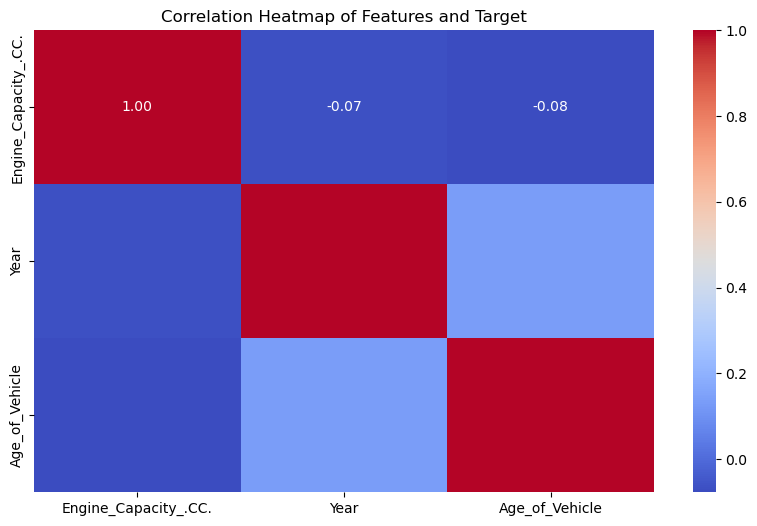

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace this with your actual dataset)
# vehicles = ...
# Define features and target
features = ['Engine_Capacity_.CC.', 'Year', 'Age_of_Vehicle']

# Create a subset of the DataFrame with the features and target
data_subset = vehicles[features]

# Compute the correlation matrix
correlation_matrix = data_subset.corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and Target')
plt.show()

In [41]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Sample data (replace this with your actual dataset)
# # vehicles = ...

# # Set the size of the plots
# plt.figure(figsize=(14, 6))

# # Boxplot for 'make' with respect to 'Age_of_Vehicle'
# plt.subplot(1, 2, 1)
# sns.boxplot(x='make', y='Age_of_Vehicle', data=vehicles)
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# plt.title('Boxplot of Make vs Age of Vehicle')

# # Boxplot for 'model' with respect to 'Age_of_Vehicle'
# plt.subplot(1, 2, 2)
# sns.boxplot(x='model', y='Age_of_Vehicle', data=vehicles)
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# plt.title('Boxplot of Model vs Age of Vehicle')

# # Adjust layout for better fit
# plt.tight_layout()
# plt.show()

In [42]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Sample data (replace this with your actual dataset)
# vehicles = ...

# Separate data into training and missing parts
train_data = vehicles[vehicles['Age_of_Vehicle'].notnull()]
missing_data = vehicles[vehicles['Age_of_Vehicle'].isnull()]

# Define features and target
features = ['Engine_Capacity_.CC.','Year']
target = 'Age_of_Vehicle'

# Handle NaN values in features separately
for feature in features:
    imputer = SimpleImputer(strategy='mean')
    train_data[feature] = imputer.fit_transform(train_data[[feature]])
    if not missing_data.empty:
        missing_data[feature] = imputer.transform(missing_data[[feature]])

# Create X (features) and y (target) for training
X_train = train_data[features]
y_train = train_data[target]

# Initialize the model
model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict missing values
if not missing_data.empty:
    X_missing = missing_data[features]
    
    # Predict and impute the missing values in Age_of_Vehicle
    missing_data['Age_of_Vehicle'] = model.predict(X_missing)

    # Combine the datasets back together
    vehicles = pd.concat([train_data, missing_data]).sort_index()

print("DataFrame after imputation:")
vehicles.head(10)

DataFrame after imputation:


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year,1st_Road_Class,2nd_Road_Class,Accident_Severity,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),LSOA_of_Accident_Location,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Urban_or_Rural_Area,Weather_Conditions,InScotland
0,200401BS00001,26 - 35,3.000000,Urban area,4.0,1588.000000,Not known,Mid Junction - on roundabout or on main road,ROVER,45 CLASSIC 16V,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,No,Front,2004,0.0,6.0,1.0,5.0,0.0,2.0,4.0,5.0,182.0,89.0,2846.0,0.0,2.0,29.0,5.0,4.0,8.0,2.0,6.0,0.0
1,200401BS00002,26 - 35,7.108167,Urban area,3.0,2042.233961,Not known,Approaching junction or waiting/parked at junc...,BMW,C1,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,109,No,Front,2004,2.0,3.0,2.0,6.0,0.0,1.0,0.0,1.0,182.0,89.0,2906.0,0.0,4.0,29.0,1.0,1.0,8.0,2.0,2.0,0.0
2,200401BS00003,26 - 35,4.000000,Urban area,NaN,998.000000,Commuting to/from work,Not at or within 20 metres of junction,NISSAN,MICRA CELEBRATION 16V,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,No,Front,2004,3.0,6.0,2.0,4.0,0.0,2.0,4.0,1.0,182.0,89.0,2854.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
3,200401BS00003,66 - 75,7.108167,Urban area,NaN,2042.233961,Not known,Mid Junction - on roundabout or on main road,LONDON TAXIS INT,TXII GOLD AUTO,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,No,Front,2004,0.0,6.0,2.0,0.0,0.0,2.0,4.0,5.0,182.0,89.0,2837.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
4,200401BS00004,26 - 35,1.000000,Urban area,4.0,124.000000,Other/Not known (2005-10),Cleared junction or waiting/parked at junction...,PIAGGIO,VESPA ET4,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,No,Front,2004,5.0,6.0,2.0,1.0,0.0,2.0,4.0,0.0,182.0,89.0,2860.0,0.0,0.0,29.0,5.0,4.0,8.0,2.0,2.0,0.0
5,200401BS00004,36 - 45,10.000000,Urban area,NaN,1781.000000,Other/Not known (2005-10),Approaching junction or waiting/parked at junc...,VOLKSWAGEN,MISSING,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,U-turn,2,109,No,Offside,2004,5.0,6.0,2.0,5.0,0.0,2.0,4.0,5.0,182.0,89.0,2829.0,0.0,0.0,29.0,5.0,4.0,4.0,2.0,6.0,0.0
6,200401BS00009,26 - 35,7.108167,Urban area,4.0,2042.233961,Not known,Approaching junction or waiting/parked at junc...,PIAGGIO,VESPA GT 125,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,No,Did not impact,2004,3.0,5.0,2.0,4.0,0.0,3.0,9.0,1.0,182.0,89.0,2872.0,0.0,0.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
7,200401BS00010,36 - 45,7.108167,Urban area,8.0,2042.233961,Other/Not known (2005-10),Not at or within 20 metres of junction,BMW,R1100 RT,Petrol,Male,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,No,Front,2004,0.0,6.0,2.0,0.0,0.0,2.0,4.0,5.0,182.0,89.0,2886.0,0.0,0.0,29.0,1.0,1.0,8.0,2.0,2.0,0.0
8,200401BS00012,46 - 55,3.000000,Urban area,NaN,2685.000000,Other/Not known (2005-10),Not at or within 20 metres of junction,MERCEDES,MISSING,Heavy oil,Male,No tow/articulation,Did not leave carriageway,0.0,Slowing or stopping,1,109,No,Back,2004,0.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,182.0,89.0,2897.0,0.0,4.0,29.0,1.0,4.0,8.0,2.0,2.0,0.0
9,200401BS00013,26 - 35,4.000000,Urban area,6.0,2300.000000,Journey as part of work,Not at or within 20 metres of junction,VOLKSWAGEN,GOLF V5,Petrol,Female,No tow/articul

Impute missing values of IMD Decile column

Check the relationship between the variable with other variables using a correlation heatmap

In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Sample data (replace this with your actual dataset)
# vehicles = ...

# List of categorical columns
categorical_columns = ['Age_Band_of_Driver', 'Driver_Home_Area_Type', 'Journey_Purpose_of_Driver', 
                       'Junction_Location', 'make', 'model', 'Propulsion_Code', 'Sex_of_Driver', 
                       'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway', 'Vehicle_Location.Restricted_Lane', 
                       'Vehicle_Manoeuvre', 'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact']

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    vehicles[col] = le.fit_transform(vehicles[col].astype(str))
    label_encoders[col] = le

# Ensure all numerical columns are of numeric type
vehicles[categorical_columns] = vehicles[categorical_columns].apply(pd.to_numeric)

print("DataFrame after label encoding:")
print(vehicles.head(10))

DataFrame after label encoding:
  Accident_Index  Age_Band_of_Driver  Age_of_Vehicle  Driver_Home_Area_Type  \
0  200401BS00001                   4        3.000000                      2   
1  200401BS00002                   4        7.108167                      2   
2  200401BS00003                   4        4.000000                      2   
3  200401BS00003                   9        7.108167                      2   
4  200401BS00004                   4        1.000000                      2   
5  200401BS00004                   5       10.000000                      2   
6  200401BS00009                   4        7.108167                      2   
7  200401BS00010                   5        7.108167                      2   
8  200401BS00012                   6        3.000000                      2   
9  200401BS00013                   4        4.000000                      2   

   Driver_IMD_Decile  Engine_Capacity_.CC.  Journey_Purpose_of_Driver  \
0                4.0     

In [44]:
# Define columns to exclude from the correlation matrix
exclude_columns = categorical_columns + ['Accident_Index','Driver_IMD_Decile']

# Compute correlation matrix excluding certain columns
corr_matrix = vehicles.drop(columns=exclude_columns)
# Plot heatmap of the correlation matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

# # Get the correlation of Driver_IMD_Decile with other features
# driver_imd_corr = corr_matrix['Driver_IMD_Decile'].sort_values(ascending=False)
# print(driver_imd_corr)


Use a feature selection technique to get important features for the model

In [45]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Define features and target
features = [col for col in vehicles.columns if col not in exclude_columns]
target = 'Driver_IMD_Decile'

# Drop rows with missing target values for training
vehicles_dropna = vehicles.dropna(subset=[target])

# Create X (features) and y (target)
X = vehicles_dropna[features]
y = vehicles_dropna[target]

# Initialize Linear Regression model
model = LinearRegression()

# Initialize RFE
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
rfe = rfe.fit(X, y)

# Get selected features
selected_features = [feature for feature, rank in zip(features, rfe.ranking_) if rank == 1]

print("Selected Features: ", selected_features)

ValueError: Input X contains NaN.
RFE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Separate data into training and missing parts
train_data = vehicles[vehicles['Driver_IMD_Decile'].notnull()]
missing_data = vehicles[vehicles['Driver_IMD_Decile'].isnull()]

# Handle NaN values in features separately
for feature in selected_features:
    imputer = SimpleImputer(strategy='mean')
    train_data[feature] = imputer.fit_transform(train_data[[feature]])
    if not missing_data.empty:
        missing_data[feature] = imputer.transform(missing_data[[feature]])

# Create X (features) and y (target) for training
X_train = train_data[selected_features]
y_train = train_data[target]

# Initialize the model
model = RandomForestRegressor()

# Train the model
model.fit(X_train, y_train)

# Predict missing values
if not missing_data.empty:
    X_missing = missing_data[selected_features]
    
    # Predict and impute the missing values in Driver_IMD_Decile
    missing_data['Driver_IMD_Decile'] = model.predict(X_missing)

    # Combine the datasets back together
    vehicles = pd.concat([train_data, missing_data]).sort_index()

print("DataFrame after imputation:")

In [ ]:
vehicles.head(10)

,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year
0,200401BS00001,4,3.000000,2,4.000000,1588.000000,4,4,400,3376,9,1,3,0,0,3,2.0,2,0,2,2004.0
1,200401BS00002,4,7.108167,2,3.000000,2042.233961,1,8,47,9022,9,1,3,0,0,3,1.0,2,0,2,2004.0
2,200401BS00003,4,4.000000,2,5.979323,998.000000,2,8,346,22504,9,1,3,0,0,13,1.0,2,0,2,2004.0
3,200401BS00003,9,7.108167,0,5.184226,2042.233961,4,3,282,31618,9,1,3,0,0,3,2.0,2,0,2,2004.0
4,200401BS00004,4,1.000000,2,4.000000,124.000000,0,8,371,32709,9,1,3,0,0,3,1.0,13,0,2,2004.0
5,200401BS00004,5,10.000000,2,3.926146,1781.000000,2,1,499,22749,9,1,3,0,0,14,2.0,2,0,4,2004.0
6,200401BS00009,4,7.108167,2,4.000000,2042.233961,2,0,371,32710,9,1,3,0,0,3,1.0,13,0,1,2004.0
7,200401BS00010,5,7.108167,2,8.000000,2042.233961,1,8,47,25867,9,1,3,0,0,13,1.0,2,0,2,2004.0
8,200401BS00012,6,3.000000,2,5.533389,2685.000000,1,7,309,22749,6,1,3,0,0,11,1.0,2,0,0,2004.0
9,200401BS00013,4,4.000000,2,6.000000,2300.000000,1,7,499,17937,9,0,3,0,0,13,1.0,2,0,4,2004.0


In [ ]:
#Rename some columns 
vehicles.rename(columns={'Engine_Capacity_.CC.': 'Engine_cap'}, inplace=True)

Impute this

In [ ]:
# # List of columns with at least 33% null values
# columns_to_impute = ['Driver_IMD_Decile', 'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'Skidding_and_Overturning']

# # Separate features and target for training the model
# X = vehicles.drop(columns_to_impute, axis=1)  # Exclude columns to be imputed
# y = vehicles['Driver_IMD_Decile']  # Target column to impute

# # Split data into training and test sets
# X_train, X_test = X[y.notnull()], X[y.isnull()]
# y_train = y[y.notnull()]

# # Train a RandomForestClassifier (or another suitable model)
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

# # Predict missing values
# y_pred = model.predict(X_test)

# # Impute missing values back into original DataFrame
# vehicles.loc[vehicles['Driver_IMD_Decile'].isnull(), 'Driver_IMD_Decile'] = y_pred

# # Impute other categorical columns similarly using the appropriate model


In [ ]:
vehicles.isnull().sum()

Accident_Index                      0
Age_Band_of_Driver                  0
Age_of_Vehicle                      0
Driver_Home_Area_Type               0
Driver_IMD_Decile                   0
Engine_Capacity_.CC.                0
Journey_Purpose_of_Driver           0
Junction_Location                   0
make                                0
model                               0
Propulsion_Code                     0
Sex_of_Driver                       0
Towing_and_Articulation             0
Vehicle_Leaving_Carriageway         0
Vehicle_Location.Restricted_Lane    0
Vehicle_Manoeuvre                   0
Vehicle_Reference                   0
Vehicle_Type                        0
Was_Vehicle_Left_Hand_Drive         0
X1st_Point_of_Impact                0
Year                                0
dtype: int64

Merge the two dataset

In [ ]:
train_raw = pd.merge(accidents, vehicles, on='Accident_Index')

In [ ]:
train_raw.head(10)

,Accident_Index,1st_Road_Class_x,1st_Road_Number,2nd_Road_Class_x,2nd_Road_Number,Accident_Severity_x,Date,Day_of_Week_x,Did_Police_Officer_Attend_Scene_of_Accident_x,Junction_Control_x,Junction_Detail_x,Latitude,Light_Conditions_x,Local_Authority_(District)_x,Local_Authority_(Highway)_x,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location_x,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control_x,Pedestrian_Crossing-Physical_Facilities_x,Police_Force_x,Road_Surface_Conditions_x,Road_Type_x,Special_Conditions_at_Site_x,Speed_limit,Time,Urban_or_Rural_Area_x,Weather_Conditions_x,Year_x,InScotland_x,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_y,1st_Road_Class_y,2nd_Road_Class_y,Accident_Severity_y,Day_of_Week_y,Did_Police_Officer_Attend_Scene_of_Accident_y,Junction_Control_y,Junction_Detail_y,Light_Conditions_y,Local_Authority_(District)_y,Local_Authority_(Highway)_y,LSOA_of_Accident_Location_y,Pedestrian_Crossing-Human_Control_y,Pedestrian_Crossing-Physical_Facilities_y,Police_Force_y,Road_Surface_Conditions_y,Road_Type_y,Special_Conditions_at_Site_y,Urban_or_Rural_Area_y,Weather_Conditions_y,InScotland_y
0,200501BS00002,2,450.0,3,0.0,2,1104883200,6,0,1,0,51.520075,1,182,89,524170.0,181650.0,-0.211708,2906,1,1,0,4,29,1,1,8,30.0,-3,2,2,2005,0,36 - 45,3.0,Data missing or out of range,NaN,8268.0,NaN,NaN,Journey as part of work,Leaving roundabout,DENNIS,NaN,Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Slowing or stopping,1,Bus or coach (17 or more pass seats),No,Nearside,2005,3.0,6.0,2.0,0.0,0.0,2.0,4.0,5.0,381.0,173.0,30266.0,0.0,0.0,41.0,3.0,4.0,8.0,0.0,2.0,0.0
1,200501BS00003,3,0.0,6,0.0,2,1104969600,4,0,2,4,51.525301,1,182,89,524520.0,182240.0,-0.206458,2854,1,2,0,0,29,1,4,8,30.0,-3,2,2,2005,0,26 - 35,5.0,Urban area,3.0,8300.0,Parked vehicle,NaN,Journey as part of work,Not at or within 20 metres of junction,DENNIS,NaN,Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead right-hand bend,1,Bus or coach (17 or more pass seats),No,Nearside,2005,0.0,5.0,2.0,2.0,0.0,3.0,0.0,5.0,381.0,173.0,30236.0,0.0,3.0,41.0,5.0,2.0,8.0,2.0,2.0,0.0
2,200501BS00004,0,3220.0,6,0.0,2,1105056000,0,0,2,4,51.482442,5,182,89,526900.0,177530.0,-0.173862,2837,1,1,0,0,29,1,4,8,30.0,-3,2,2,2005,0,46 - 55,4.0,Urban area,1.0,1769.0,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,NISSAN,ALMERA SE AUTO,Petrol,Female,NaN,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Car,No,Front,2005,2.0,6.0,2.0,0.0,0.0,2.0,4.0,3.0,341.0,173.0,30156.0,0.0,0.0,41.0,5.0,4.0,8.0,0.0,6.0,0.0
3,200501BS00005,5,0.0,6,0.0,2,1105315200,1,0,2,4,51.495752,0,182,89,528060.0,179040.0,-0.156618,2860,1,1,0,0,29,5,4,8,30.0,-3,2,2,2005,0,46 - 55,10.0,Data missing or out of range,NaN,85.0,Kerb,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,HONDA,NaN,Petrol,Male,Skidded,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,No,Front,2005,5.0,6.0,1.0,0.0,0.0,3.0,6.0,5.0,381.0,173.0,30208.0,0.0,0.0,41.0,3.0,4.0,8.0,2.0,2.0,0.0
4,200501BS00006,5,0.0,6,0.0,2,1105401600,5,0,2,4,51.515540,5,182,89,524770.0,181160.0,-0.203238,2829,1,2,0,0,29,5,4,4,30.0,-3,2,6,2005,0,46 - 55,1.0,Urban area,4.0,2976.0,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,AUDI,A4 SPORT CABRIOLET AUTO,Petrol,Male,NaN,No tow/articulation,Did not leave carriageway,0.0,Moving off,1,Car,No,Did not impact,2005,5.0,5.0,2.0,1.0,0.0,3.0,5.0,5.0,381.0,173.0,30259.0,0.0,0.0,41.0,1.0,4.0,8.0,2.0,2.0,0.0
5,200501BS00

In [ ]:
train_raw.shape

(2058408, 76)

In [ ]:
train_raw.info()

In [ ]:
train_raw.dropna(axis=1, inplace=True)

In [ ]:
train_raw.shape

(2058408, 46)

In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058408 entries, 0 to 2058407
Data columns (total 46 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   Accident_Index                                 object 
 1   1st_Road_Class_x                               int64  
 2   1st_Road_Number                                float64
 3   2nd_Road_Class_x                               int64  
 4   2nd_Road_Number                                float64
 5   Accident_Severity_x                            int64  
 6   Date                                           int64  
 7   Day_of_Week_x                                  int64  
 8   Did_Police_Officer_Attend_Scene_of_Accident_x  int64  
 9   Junction_Control_x                             int64  
 10  Junction_Detail_x                              int64  
 11  Latitude                                       float64
 12  Light_Conditions_x                        

In [ ]:
train_raw.drop_duplicates()

,Accident_Index,1st_Road_Class_x,1st_Road_Number,2nd_Road_Class_x,2nd_Road_Number,Accident_Severity_x,Date,Day_of_Week_x,Did_Police_Officer_Attend_Scene_of_Accident_x,Junction_Control_x,Junction_Detail_x,Latitude,Light_Conditions_x,Local_Authority_(District)_x,Local_Authority_(Highway)_x,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location_x,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control_x,Pedestrian_Crossing-Physical_Facilities_x,Police_Force_x,Road_Surface_Conditions_x,Road_Type_x,Special_Conditions_at_Site_x,Speed_limit,Time,Urban_or_Rural_Area_x,Weather_Conditions_x,Year_x,InScotland_x,Age_Band_of_Driver,Driver_Home_Area_Type,Journey_Purpose_of_Driver,Junction_Location,Sex_of_Driver,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_y
0,200501BS00002,2,450.0,3,0.0,2,1104883200,6,0,1,0,51.520075,1,182,89,524170.0,181650.0,-0.211708,2906,1,1,0,4,29,1,1,8,30.0,-3,2,2,2005,0,36 - 45,Data missing or out of range,Journey as part of work,Leaving roundabout,Male,No tow/articulation,Did not leave carriageway,Slowing or stopping,1,Bus or coach (17 or more pass seats),No,Nearside,2005
1,200501BS00003,3,0.0,6,0.0,2,1104969600,4,0,2,4,51.525301,1,182,89,524520.0,182240.0,-0.206458,2854,1,2,0,0,29,1,4,8,30.0,-3,2,2,2005,0,26 - 35,Urban area,Journey as part of work,Not at or within 20 metres of junction,Male,No tow/articulation,Did not leave carriageway,Going ahead right-hand bend,1,Bus or coach (17 or more pass seats),No,Nearside,2005
2,200501BS00004,0,3220.0,6,0.0,2,1105056000,0,0,2,4,51.482442,5,182,89,526900.0,177530.0,-0.173862,2837,1,1,0,0,29,1,4,8,30.0,-3,2,2,2005,0,46 - 55,Urban area,Other/Not known (2005-10),Not at or within 20 metres of junction,Female,No tow/articulation,Did not leave carriageway,Going ahead other,1,Car,No,Front,2005
3,200501BS00005,5,0.0,6,0.0,2,1105315200,1,0,2,4,51.495752,0,182,89,528060.0,179040.0,-0.156618,2860,1,1,0,0,29,5,4,8,30.0,-3,2,2,2005,0,46 - 55,Data missing or out of range,Other/Not known (2005-10),Not at or within 20 metres of junction,Male,No tow/articulation,Did not leave carriageway,Going ahead other,1,Motorcycle 125cc and under,No,Front,2005
4,200501BS00006,5,0.0,6,0.0,2,1105401600,5,0,2,4,51.515540,5,182,89,524770.0,181160.0,-0.203238,2829,1,2,0,0,29,5,4,4,30.0,-3,2,6,2005,0,46 - 55,Urban area,Other/Not known (2005-10),Not at or within 20 metres of junction,Male,No tow/articulation,Did not leave carriageway,Moving off,1,Car,No,Did not impact,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058403,2016984131116,2,7020.0,3,49.0,2,1477958400,5,0,3,0,55.005033,5,105,51,316143.0,568615.0,-3.312631,3,2,2,0,0,11,1,4,8,60.0,-3,0,2,2016,1,21 - 25,Urban area,Not known,Mid Junction - on roundabout or on main road,Female,No tow/articulation,Did not leave carriageway,Going ahead other,1,Car,No,Front,2016
2058404,2016984131116,2,7020.0,3,49.0,2,1477958400,5,0,3,0,55.005033,5,105,51,316143.0,568615.0,-3.312631,3,2,2,0,0,11,1,4,8,60.0,-3,0,2,2016,1,56 - 65,Small town,Commuting to/from work,Mid Junction - on roundabout or on main road,Female,No tow/articulation,Offside,Going ahead other,2,Car,No,Front,2016
2058405,2016984131216,1,74.0,6,0.0,2,1477526400,4,0,2,4,55.048803,3,105,51,322903.0,573365.0,-3.208249,3,1,1,0,0,11,5,1,8,70.0,-3,0,2,2016,1,56 - 65,Urban area,Journey as part of work,Not at or within 20 metres of junction,Male,No tow/articulation,Offside on to central reservation,Going ahead other,1,Goods 7.5 tonnes mgw and over,No,Offside,2016
2058406,2016984131316,2,724.0,6,0.0,2,1477699200,2,0,2,4,54.989597,1,105,51,318673.0,566850.0,-3.272584,3,3,1,0,0,11,1,4,8,40.0,-3,0,2,2016,1,16 - 20,Urban area,Not known,Not at or within 20 metres of junction,Male,No tow/articulation,Offside,Going ahead other,1,Ca

In [ ]:
train_raw.isnull().sum()

Accident_Index                                   0
1st_Road_Class_x                                 0
1st_Road_Number                                  0
2nd_Road_Class_x                                 0
2nd_Road_Number                                  0
Accident_Severity_x                              0
Date                                             0
Day_of_Week_x                                    0
Did_Police_Officer_Attend_Scene_of_Accident_x    0
Junction_Control_x                               0
Junction_Detail_x                                0
Latitude                                         0
Light_Conditions_x                               0
Local_Authority_(District)_x                     0
Local_Authority_(Highway)_x                      0
Location_Easting_OSGR                            0
Location_Northing_OSGR                           0
Longitude                                        0
LSOA_of_Accident_Location_x                      0
Number_of_Casualties           

In [ ]:
train_raw.to_csv("train_raw.csv")

In [ ]:
train_raw.head(10)

,Accident_Index,1st_Road_Class_x,1st_Road_Number,2nd_Road_Class_x,2nd_Road_Number,Accident_Severity_x,Date,Day_of_Week_x,Did_Police_Officer_Attend_Scene_of_Accident_x,Junction_Control_x,Junction_Detail_x,Latitude,Light_Conditions_x,Local_Authority_(District)_x,Local_Authority_(Highway)_x,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location_x,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control_x,Pedestrian_Crossing-Physical_Facilities_x,Police_Force_x,Road_Surface_Conditions_x,Road_Type_x,Special_Conditions_at_Site_x,Speed_limit,Time,Urban_or_Rural_Area_x,Weather_Conditions_x,Year_x,InScotland_x,Age_Band_of_Driver,Driver_Home_Area_Type,Journey_Purpose_of_Driver,Junction_Location,Sex_of_Driver,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_y
0,200501BS00002,2,450.0,3,0.0,2,1104883200,6,0,1,0,51.520075,1,182,89,524170.0,181650.0,-0.211708,2906,1,1,0,4,29,1,1,8,30.0,-3,2,2,2005,0,36 - 45,Data missing or out of range,Journey as part of work,Leaving roundabout,Male,No tow/articulation,Did not leave carriageway,Slowing or stopping,1,Bus or coach (17 or more pass seats),No,Nearside,2005
1,200501BS00003,3,0.0,6,0.0,2,1104969600,4,0,2,4,51.525301,1,182,89,524520.0,182240.0,-0.206458,2854,1,2,0,0,29,1,4,8,30.0,-3,2,2,2005,0,26 - 35,Urban area,Journey as part of work,Not at or within 20 metres of junction,Male,No tow/articulation,Did not leave carriageway,Going ahead right-hand bend,1,Bus or coach (17 or more pass seats),No,Nearside,2005
2,200501BS00004,0,3220.0,6,0.0,2,1105056000,0,0,2,4,51.482442,5,182,89,526900.0,177530.0,-0.173862,2837,1,1,0,0,29,1,4,8,30.0,-3,2,2,2005,0,46 - 55,Urban area,Other/Not known (2005-10),Not at or within 20 metres of junction,Female,No tow/articulation,Did not leave carriageway,Going ahead other,1,Car,No,Front,2005
3,200501BS00005,5,0.0,6,0.0,2,1105315200,1,0,2,4,51.495752,0,182,89,528060.0,179040.0,-0.156618,2860,1,1,0,0,29,5,4,8,30.0,-3,2,2,2005,0,46 - 55,Data missing or out of range,Other/Not known (2005-10),Not at or within 20 metres of junction,Male,No tow/articulation,Did not leave carriageway,Going ahead other,1,Motorcycle 125cc and under,No,Front,2005
4,200501BS00006,5,0.0,6,0.0,2,1105401600,5,0,2,4,51.515540,5,182,89,524770.0,181160.0,-0.203238,2829,1,2,0,0,29,5,4,4,30.0,-3,2,6,2005,0,46 - 55,Urban area,Other/Not known (2005-10),Not at or within 20 metres of junction,Male,No tow/articulation,Did not leave carriageway,Moving off,1,Car,No,Did not impact,2005
5,200501BS00006,5,0.0,6,0.0,2,1105401600,5,0,2,4,51.515540,5,182,89,524770.0,181160.0,-0.203238,2829,1,2,0,0,29,5,4,4,30.0,-3,2,6,2005,0,26 - 35,Urban area,Other/Not known (2005-10),Not at or within 20 metres of junction,Female,No tow/articulation,Did not leave carriageway,Going ahead other,2,Motorcycle 125cc and under,No,Did not impact,2005
6,200501BS00007,3,0.0,5,0.0,2,1105574400,4,0,3,9,51.512695,1,182,89,524220.0,180830.0,-0.211277,2872,1,2,0,0,29,1,4,8,30.0,-3,2,2,2005,0,26 - 35,Data missing or out of range,Other/Not known (2005-10),Approaching junction or waiting/parked at junc...,Male,No tow/articulation,Did not leave carriageway,Going ahead other,1,Motorcycle 125cc and under,No,Front,2005
7,200501BS00007,3,0.0,5,0.0,2,1105574400,4,0,3,9,51.512695,1,182,89,524220.0,180830.0,-0.211277,2872,1,2,0,0,29,1,4,8,30.0,-3,2,2,2005,0,36 - 45,Urban area,Other/Not known (2005-10),Approaching junction or waiting/parked at junc...,Male,No tow/articulation,Did not leave carriageway,Parked,2,Car,No,Back,2005
8,200501BS00009,0,315.0,6,0.0,2,1105660800,0,0,2,4,51.502260,5,182,89,525890.0,179710.0,-0.187623,2886,2,1,0,0,29,1,1,8,30.0,-3,2,2,2005,0,66 - 75,Urban area,Other/Not known (2005-10),Not at or within 20 metres of junction,Male,No tow/articulation,Nearside,Going ahead other,1,Car,No,Front,2005
9,200501BS00012,0,4.0,2,325.0,2,1105833600,3,0,1,0,51.494902,1,182,89,526240.0,178900.0,-0.182872,2832,1